In [4]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [5]:
### Step 1: Import the CRYPTO dataset into a Pandas DataFrame.

In [6]:
# Import the Crypto dataset into a Pandas Dataframe

bitcoin_df = pd.read_csv(
    Path("Resources/bitcoin-fear-greed-dataset.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
bitcoin_df.head()

C:\Users\chris\AppData\Local\Temp\ipykernel_38464\201517330.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  bitcoin_df = pd.read_csv(


,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2018-02-01,30.0,Fear,9170.540039,9959400448
2018-02-02,15.0,Extreme Fear,8830.750000,12726899712
2018-02-03,40.0,Fear,9174.910156,7263790080
2018-02-04,24.0,Extreme Fear,8277.009766,7073549824
2018-02-05,11.0,Extreme Fear,6955.270020,9285289984


<Axes: xlabel='Date'>

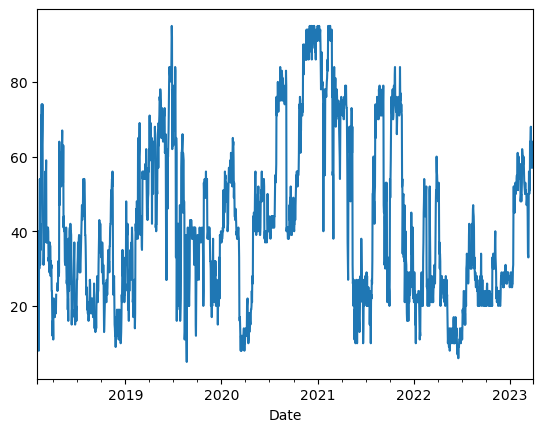

In [7]:
# Plot the actual returns versus the strategy returns
bitcoin_df["Value"].plot()

In [8]:
# Filter the date index and close columns
signals_df = bitcoin_df.loc[:, ["Value", "BTC_Closing"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual_Returns"] = signals_df["BTC_Closing"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Value,BTC_Closing,Actual_Returns
Date,,,
2018-02-02,15.0,8830.750000,-0.037052
2018-02-03,40.0,9174.910156,0.038973
2018-02-04,24.0,8277.009766,-0.097865
2018-02-05,11.0,6955.270020,-0.159688
2018-02-06,8.0,7754.000000,0.114838


,Value,BTC_Closing,Actual_Returns
Date,,,
2023-03-27,64.0,27139.888672,-0.030522
2023-03-28,59.0,27268.130859,0.004725
2023-03-29,57.0,28348.441406,0.039618
2023-03-30,60.0,28033.562500,-0.011107
2023-03-31,63.0,28478.484375,0.015871


In [9]:
### Step 2: Generate trading signals using short- and long-window SMA values. 

In [10]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['BTC_Closing'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['BTC_Closing'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())

,Value,BTC_Closing,Actual_Returns,SMA_Fast,SMA_Slow
Date,,,,,
2018-05-15,40.0,8510.379883,-0.023680,8614.000000,8901.235811
2018-05-16,32.0,8368.830078,-0.016633,8579.985107,8896.616611
2018-05-17,31.0,8094.319824,-0.032802,8422.579956,8885.810708
2018-05-18,37.0,8250.969727,0.019353,8306.124878,8885.550308
2018-05-19,31.0,8247.179688,-0.000459,8240.324829,8898.469404


In [11]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual_Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual_Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())

,Value,BTC_Closing,Actual_Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,,
2018-05-15,40.0,8510.379883,-0.023680,8614.000000,8901.235811,-1.0
2018-05-16,32.0,8368.830078,-0.016633,8579.985107,8896.616611,-1.0
2018-05-17,31.0,8094.319824,-0.032802,8422.579956,8885.810708,-1.0
2018-05-18,37.0,8250.969727,0.019353,8306.124878,8885.550308,1.0
2018-05-19,31.0,8247.179688,-0.000459,8240.324829,8898.469404,-1.0


In [12]:
signals_df['Signal'].value_counts()

Signal
 1.0    917
-1.0    865
Name: count, dtype: int64

In [13]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy_Returns'] = signals_df['Actual_Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())

,Value,BTC_Closing,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns
Date,,,,,,,
2018-05-15,40.0,8510.379883,-0.023680,8614.000000,8901.235811,-1.0,NaN
2018-05-16,32.0,8368.830078,-0.016633,8579.985107,8896.616611,-1.0,0.016633
2018-05-17,31.0,8094.319824,-0.032802,8422.579956,8885.810708,-1.0,0.032802
2018-05-18,37.0,8250.969727,0.019353,8306.124878,8885.550308,1.0,-0.019353
2018-05-19,31.0,8247.179688,-0.000459,8240.324829,8898.469404,-1.0,-0.000459


In [14]:
### Step 3: Split the data into training and testing datasets.

In [15]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['Value','SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,Value,SMA_Fast,SMA_Slow
Date,,,
2018-05-16,40.0,8614.000000,8901.235811
2018-05-17,32.0,8579.985107,8896.616611
2018-05-18,31.0,8422.579956,8885.810708
2018-05-19,37.0,8306.124878,8885.550308
2018-05-20,31.0,8240.324829,8898.469404


In [16]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    917
-1.0    865
Name: count, dtype: int64

In [17]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-05-16 00:00:00


In [18]:
# Select the ending period for the training data with an offset of 24 months
training_end = X.index.min() + DateOffset(months=24)

# Display the training end date
print(training_end)

2020-05-16 00:00:00


In [19]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()
X_train.tail()
X_train.count()

Value       732
SMA_Fast    732
SMA_Slow    732
dtype: int64

In [20]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(months=0):]
y_test = y.loc[training_end+DateOffset(months=0):]

# Review the X_test DataFrame
X_test.head()
X_test.tail()
X_test.count()

Value       1050
SMA_Fast    1050
SMA_Slow    1050
dtype: int64

In [21]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [22]:
### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data.

In [23]:
# From SVM, instantiate SVC classifier model instance
from sklearn import svm
from sklearn.metrics import classification_report

svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [24]:
### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [25]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_training = svm_model.predict(X_train_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_training_report = classification_report(y_train, testing_signal_training)

# Print the classification report
print(svm_training_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.32      0.42       354
         1.0       0.56      0.81      0.66       378

    accuracy                           0.57       732
   macro avg       0.58      0.56      0.54       732
weighted avg       0.58      0.57      0.55       732



In [26]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.10      0.16       510
         1.0       0.51      0.88      0.64       540

    accuracy                           0.50      1050
   macro avg       0.47      0.49      0.40      1050
weighted avg       0.47      0.50      0.41      1050



In [27]:
### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [28]:
# Create a new empty predictions DataFrame:
predictions_df = pd.DataFrame(index=X_test.index)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df["Predicted"] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df["Actual_Returns"] = signals_df["Actual_Returns"]

# Add the strategy returns to the DataFrame
predictions_df["Strategy_Returns"] = (
    predictions_df["Actual_Returns"] * predictions_df["Predicted"]
)

# Review the DataFrame
display(predictions_df.tail(10))

,Predicted,Actual_Returns,Strategy_Returns
Date,,,
2023-03-22,1.0,-0.030820,-0.030820
2023-03-23,1.0,0.037592,0.037592
2023-03-24,1.0,-0.029671,-0.029671
2023-03-25,1.0,0.000052,0.000052
2023-03-26,1.0,0.018172,0.018172
2023-03-27,1.0,-0.030522,-0.030522
2023-03-28,1.0,0.004725,0.004725
2023-03-29,1.0,0.039618,0.039618
2023-03-30,1.0,-0.011107,-0.011107


In [29]:
### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<Axes: xlabel='Date'>

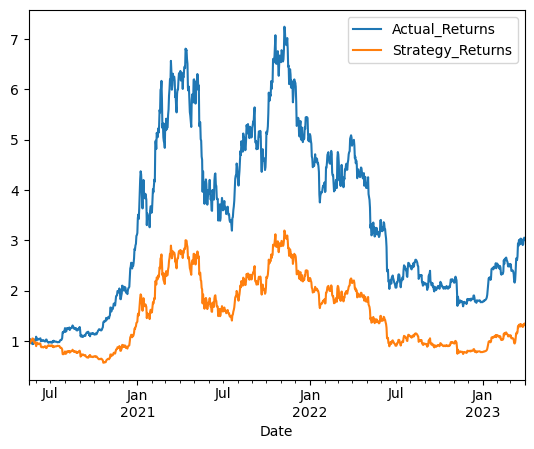

In [30]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot()

In [31]:
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta
import time

# Initialize Alpaca API
api = tradeapi.REST('PKD8BNDR0EC8XAJCLZDY', 'gAgLE5vv1g90cncwc0SQO4K13TeeFwI2gr7caf7p', base_url='https://paper-api.alpaca.markets')  # Use the paper trading API for testing

# Get the current date and time
current_datetime = datetime.now()
#current_date = current_datetime.strftime('%Y-%m-%d')
current_hour = current_datetime.strftime('%H:%M:%S')
start_datetime = current_datetime - timedelta(days=30)

# Slicing by current date minus 30 days in the past to make our data and hour
sliced_df = predictions_df["Predicted"].loc[f'{start_datetime} {current_hour}':]

# if using live hourly data use this
# sliced_df = predictions_df["Predicted"].loc[f'{current_date} {current_hour}':]

while True:
    # Get account information to check available quantity of BTCUSD
    position_info = api.get_position('ETHUSD')
    btcusd_qty_available = float(position_info.qty)
    # sliced_df contains our predictions for the training set
    # You may adjust this based on your specific signal values (e.g., -1 for sell, 1 for buy, 0 for hold)
    for i, signal in enumerate(sliced_df):
        if signal == 1 and btcusd_qty_available > 0:  # Buy signal and available quantity is greater than 0
            # Place a market order to buy
            api.submit_order(
                symbol='ETHUSD',  # Replace with the stock symbol you want to trade
                qty=1,  # Adjust the quantity based on your strategy
                side='buy',
                type='market',
                time_in_force='gtc'
            )
        elif signal == -1 and btcusd_qty_available > 0:  # Sell signal and available quantity is greater than 0
            # Place a market order to sell
            api.submit_order(
                symbol='ETHUSD',
                qty=1,
                side='sell',
                type='market',
                time_in_force='gtc'
        )
        # Sleep for a specific duration (adjust as needed)
        time.sleep(60) # Sleep for 60 seconds
        #time.sleep(3600) # Sleep for 1 hour to mimic dataset hourly data

KeyboardInterrupt: 